In [1]:
# install kaggle package
!pip install -q kaggle

In [2]:
# upload kaggle.json
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"leonardusvirmus","key":"cc506a831a11ff741c991ff923f70662"}'}

In [3]:
# create directory and change file permissions
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!ls ~/.kaggle

kaggle.json


In [4]:
# download dataset
!kaggle datasets download -d hgultekin/bbcnewsarchive

100% 1.81M/1.81M [00:00<00:00, 2.56MB/s]
100% 1.81M/1.81M [00:00<00:00, 2.26MB/s]


In [5]:
# unzip and see the list of datasets
!mkdir bbcnewsarchive
!unzip bbcnewsarchive.zip -d bbcnewsarchive
!ls bbcnewsarchive

Archive:  bbcnewsarchive.zip
  inflating: bbcnewsarchive/bbc-news-data.csv  
bbc-news-data.csv


##Load dataset

In [6]:
#import library
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize,sent_tokenize
from bs4 import BeautifulSoup
import re,string,unicodedata
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
from sklearn.model_selection import train_test_split
from string import punctuation
from nltk import pos_tag
from nltk.corpus import wordnet
import keras
from keras.preprocessing import text, sequence
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [7]:
#import data to variables for reading
news_data = pd.read_csv('bbcnewsarchive/bbc-news-data.csv', sep='\t')
news_data.head(10)

,category,filename,title,content
0,business,001.txt,Ad sales boost Time Warner profit,Quarterly profits at US media giant TimeWarne...
1,business,002.txt,Dollar gains on Greenspan speech,The dollar has hit its highest level against ...
2,business,003.txt,Yukos unit buyer faces loan claim,The owners of embattled Russian oil giant Yuk...
3,business,004.txt,High fuel prices hit BA's profits,British Airways has blamed high fuel prices f...
4,business,005.txt,Pernod takeover talk lifts Domecq,Shares in UK drinks and food firm Allied Dome...
5,business,006.txt,Japan narrowly escapes recession,Japan's economy teetered on the brink of a te...
6,business,007.txt,Jobs growth still slow in the US,The US created fewer jobs than expected in Ja...
7,business,008.txt,India calls for fair trade rules,"India, which attends the G7 meeting of seven ..."
8,business,009.txt,Ethiopia's crop production up 24%,Ethiopia produced 14.27 million tonnes of cro...
9,business,010.txt,Court rejects $280bn tobacco case,A US government claim accusing the country's ...


In [11]:
# total data
news_data.shape

(2225, 4)

In [13]:
# Check if there is a Null value
news_data.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2225 entries, 0 to 2224
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   category  2225 non-null   object
 1   filename  2225 non-null   object
 2   title     2225 non-null   object
 3   content   2225 non-null   object
dtypes: object(4)
memory usage: 69.7+ KB
None


In [17]:
news_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2225 entries, 0 to 2224
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   category  2225 non-null   object
 1   filename  2225 non-null   object
 2   title     2225 non-null   object
 3   content   2225 non-null   object
dtypes: object(4)
memory usage: 69.7+ KB


In [18]:
# categories
news_data.category.value_counts()

sport            511
business         510
politics         417
tech             401
entertainment    386
Name: category, dtype: int64

In [ ]:
# delete unused columns
news_data = news_data.drop(columns=['filename'])
news_data

,category,title,content
0,business,Ad sales boost Time Warner profit,Quarterly profits at US media giant TimeWarne...
1,business,Dollar gains on Greenspan speech,The dollar has hit its highest level against ...
2,business,Yukos unit buyer faces loan claim,The owners of embattled Russian oil giant Yuk...
3,business,High fuel prices hit BA's profits,British Airways has blamed high fuel prices f...
4,business,Pernod takeover talk lifts Domecq,Shares in UK drinks and food firm Allied Dome...
...,...,...,...
2220,tech,BT program to beat dialler scams,BT is introducing two initiatives to help bea...
2221,tech,Spam e-mails tempt net shoppers,Computer users across the world continue to i...
2222,tech,Be careful how you code,A new European directive could put software w...
2223,tech,US cyber security chief resigns,The man making sure US computer networks are ...


In [19]:
#count the number of titles
news_data.title.count()

2225

In [20]:
# combine column title and content
news_data['text'] = news_data['title'] + " " + news_data['content']
news_data

,category,filename,title,content,text
0,business,001.txt,Ad sales boost Time Warner profit,Quarterly profits at US media giant TimeWarne...,Ad sales boost Time Warner profit Quarterly p...
1,business,002.txt,Dollar gains on Greenspan speech,The dollar has hit its highest level against ...,Dollar gains on Greenspan speech The dollar h...
2,business,003.txt,Yukos unit buyer faces loan claim,The owners of embattled Russian oil giant Yuk...,Yukos unit buyer faces loan claim The owners ...
3,business,004.txt,High fuel prices hit BA's profits,British Airways has blamed high fuel prices f...,High fuel prices hit BA's profits British Air...
4,business,005.txt,Pernod takeover talk lifts Domecq,Shares in UK drinks and food firm Allied Dome...,Pernod takeover talk lifts Domecq Shares in U...
...,...,...,...,...,...
2220,tech,397.txt,BT program to beat dialler scams,BT is introducing two initiatives to help bea...,BT program to beat dialler scams BT is introd...
2221,tech,398.txt,Spam e-mails tempt net shoppers,Computer users across the world continue to i...,Spam e-mails tempt net shoppers Computer user...
2222,tech,399.txt,Be careful how you code,A new European directive could put software w...,Be careful how you code A new European direct...
2223,tech,400.txt,US cyber security chief resigns,The man making sure US computer networks are ...,US cyber security chief resigns The man makin...


## Data Cleaning

In [21]:
stwd = set(stopwords.words('english'))
punctuation = list(string.punctuation)
stwd.update(punctuation)

In [24]:
nltk.download('stopwords')
stwd = set(stopwords.words("english"))

def strip_html(text):
    soup = BeautifulSoup(text, "html.parser")
    return soup.get_text()

def remove_between_square_brackets(text):
    return re.sub(r'\[[^]]*\]', '', text)

def remove_url(text):
    return re.sub(r'http\S+', '', text)

def remove_stopwords(text):
    words = text.split()
    filtered_words = [word for word in words if word.strip().lower() not in stwd]
    return " ".join(filtered_words)

def denoise_text(text):
    text = strip_html(text)
    text = remove_between_square_brackets(text)
    text = remove_url(text)
    text = remove_stopwords(text)
    return text

news_data['text'] = news_data['text'].apply(denoise_text)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Jumlah kata

In [25]:
def get_corpus(text):
    words = [word.strip() for i in text for word in i.split()]
    return words
corpus = get_corpus(news_data['text'])
corpus[:10]

['Ad',
 'sales',
 'boost',
 'Time',
 'Warner',
 'profit',
 'Quarterly',
 'profits',
 'US',
 'media']

In [28]:
from collections import Counter
counter = Counter(corpus)
most_common = dict(counter.most_common(10))
most_common

{'said': 4899,
 '-': 3193,
 'Mr': 2979,
 'would': 2555,
 'also': 2098,
 'people': 1695,
 'said.': 1499,
 'could': 1494,
 'new': 1490,
 'one': 1376}

In [31]:
from sklearn.feature_extraction.text import CountVectorizer
def get_top_text_ngrams(corpus, n, g):
    vectorizer = CountVectorizer(ngram_range=(g, g))
    vectorizer.fit(corpus)
    bag_of_words = vectorizer.transform(corpus)
    word_sum = bag_of_words.sum(axis=0)
    word_freq = [(word, word_sum[0, idx]) for word, idx in vectorizer.vocabulary_.items()]
    word_freq = sorted(word_freq, key=lambda x: x[1], reverse=True)
    return word_freq[:n]
top_ngrams = get_top_text_ngrams(corpus, n=10, g=2)
top_ngrams


[('year old', 305),
 ('we re', 137),
 ('we ve', 105),
 ('kilroy silk', 105),
 ('high definition', 80),
 ('so called', 74),
 ('long term', 66),
 ('they re', 56),
 ('anti virus', 56),
 ('hip hop', 56)]

<Axes: >

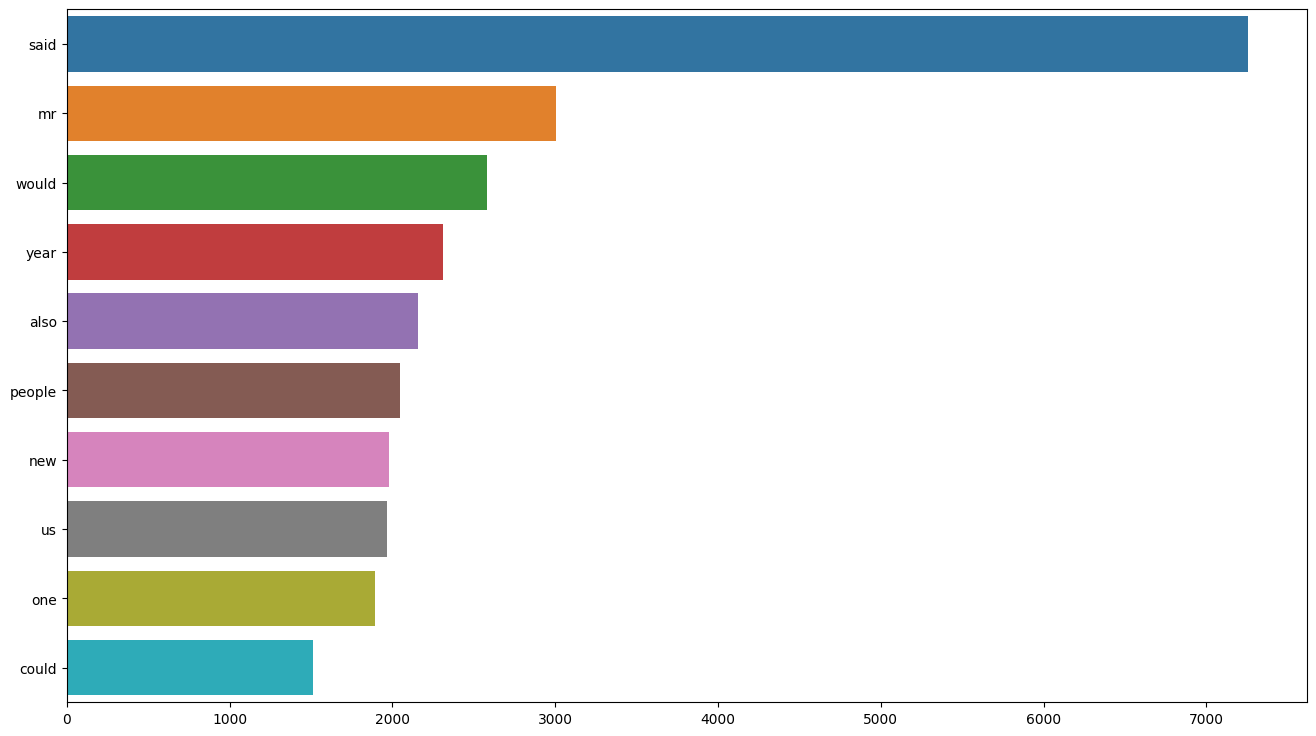

In [32]:
plt.figure(figsize = (16,9))
most_common = get_top_text_ngrams(news_data.text,10,1)
most_common = dict(most_common)
sns.barplot(x=list(most_common.values()),y=list(most_common.keys()))

## Encoding & Splitting Data

In [33]:
# data category one-hot-encoding
category = pd.get_dummies(news_data.category)
new_cat = pd.concat([news_data, category], axis=1)
new_cat = new_cat.drop(columns='category')
new_cat.head(10)

,filename,title,content,text,business,entertainment,politics,sport,tech
0,001.txt,Ad sales boost Time Warner profit,Quarterly profits at US media giant TimeWarne...,Ad sales boost Time Warner profit Quarterly pr...,1,0,0,0,0
1,002.txt,Dollar gains on Greenspan speech,The dollar has hit its highest level against ...,Dollar gains Greenspan speech dollar hit highe...,1,0,0,0,0
2,003.txt,Yukos unit buyer faces loan claim,The owners of embattled Russian oil giant Yuk...,Yukos unit buyer faces loan claim owners embat...,1,0,0,0,0
3,004.txt,High fuel prices hit BA's profits,British Airways has blamed high fuel prices f...,High fuel prices hit BA's profits British Airw...,1,0,0,0,0
4,005.txt,Pernod takeover talk lifts Domecq,Shares in UK drinks and food firm Allied Dome...,Pernod takeover talk lifts Domecq Shares UK dr...,1,0,0,0,0
5,006.txt,Japan narrowly escapes recession,Japan's economy teetered on the brink of a te...,Japan narrowly escapes recession Japan's econo...,1,0,0,0,0
6,007.txt,Jobs growth still slow in the US,The US created fewer jobs than expected in Ja...,Jobs growth still slow US US created fewer job...,1,0,0,0,0
7,008.txt,India calls for fair trade rules,"India, which attends the G7 meeting of seven ...","India calls fair trade rules India, attends G7...",1,0,0,0,0
8,009.txt,Ethiopia's crop production up 24%,Ethiopia produced 14.27 million tonnes of cro...,Ethiopia's crop production 24% Ethiopia produc...,1,0,0,0,0
9,010.txt,Court rejects $280bn tobacco case,A US government claim accusing the country's ...,Court rejects $280bn tobacco case US governmen...,1,0,0,0,0


In [ ]:
# change dataframe value to numpy array
news = new_cat['text'].values
label = new_cat[['business', 'entertainment', 'politics', 'sport', 'tech']].values
news

In [37]:
#cek label
label

array([[1, 0, 0, 0, 0],
       [1, 0, 0, 0, 0],
       [1, 0, 0, 0, 0],
       ...,
       [0, 0, 0, 0, 1],
       [0, 0, 0, 0, 1],
       [0, 0, 0, 0, 1]], dtype=uint8)

In [38]:
x_train,x_test,y_train,y_test = train_test_split(news, label,test_size = 0.2,shuffle=True)

##Tokenizer dan Pemodelan Sequential dengan Embedding dan LSTM

In [39]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import LSTM,Dense,Embedding,Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

In [44]:
vocab_size = 10000
max_len = 200
trunc_type = "post"
oov_tok = "<OOV>"

tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(x_train)

word_index = tokenizer.word_index

sequences_train = tokenizer.texts_to_sequences(x_train)
sequences_test = tokenizer.texts_to_sequences(x_test)

pad_train = pad_sequences(sequences_train, maxlen=max_len, truncating=trunc_type)
pad_test = pad_sequences(sequences_test, maxlen=max_len, truncating=trunc_type)

print("Shape of pad_test:", pad_test.shape)
print ("Pad Train :", pad_train)
print ("Pad Test :", pad_test)

Shape of pad_test: (445, 200)
Pad Train : [[   0    0    0 ...   16  381  116]
 [   0    0    0 ... 2300  733 1237]
 [ 869  366 4590 ...   89  634 3198]
 ...
 [ 247  161  373 ...  247   16 7911]
 [ 181 3014    1 ...   71 4600  790]
 [1206  365    1 ...  636  646 5607]]
Pad Test : [[3590  852 6146 ... 1224   36    1]
 [   0    0    0 ...   16 1402   10]
 [   0    0    0 ... 2378  166  396]
 ...
 [   0    0    0 ...    1    1 3454]
 [   1    1 8531 ... 6288    1 1496]
 [2992 2221  665 ... 1856  119 5165]]


In [48]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(input_dim=vocab_size, output_dim=64, input_length=max_len),
    tf.keras.layers.LSTM(128),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(5, activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 200, 64)           640000    
                                                                 
 lstm_2 (LSTM)               (None, 128)               98816     
                                                                 
 dense_4 (Dense)             (None, 128)               16512     
                                                                 
 dropout_2 (Dropout)         (None, 128)               0         
                                                                 
 dense_5 (Dense)             (None, 5)                 645       
                                                                 
Total params: 755,973
Trainable params: 755,973
Non-trainable params: 0
_________________________________________________________________


In [49]:
# callback
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('accuracy')>0.93 and logs.get('val_accuracy')>0.93):
      self.model.stop_training = True
      print("\n akurasi dari training set and the validation set telah terpenuhi > 93%!")
callbacks = myCallback()

In [50]:
num_epochs = 50
history = model.fit(pad_train, y_train, epochs=num_epochs,
                    validation_data=(pad_test, y_test), verbose=2, callbacks=[callbacks])

Epoch 1/50
56/56 - 23s - loss: 1.5840 - accuracy: 0.2899 - val_loss: 1.3908 - val_accuracy: 0.4000 - 23s/epoch - 405ms/step
Epoch 2/50
56/56 - 20s - loss: 1.0573 - accuracy: 0.5416 - val_loss: 0.8516 - val_accuracy: 0.5843 - 20s/epoch - 351ms/step
Epoch 3/50
56/56 - 19s - loss: 0.5680 - accuracy: 0.7034 - val_loss: 0.6556 - val_accuracy: 0.7393 - 19s/epoch - 344ms/step
Epoch 4/50
56/56 - 17s - loss: 0.2225 - accuracy: 0.9230 - val_loss: 0.5229 - val_accuracy: 0.8022 - 17s/epoch - 303ms/step
Epoch 5/50
56/56 - 20s - loss: 0.0894 - accuracy: 0.9798 - val_loss: 0.5114 - val_accuracy: 0.8607 - 20s/epoch - 350ms/step
Epoch 6/50
56/56 - 17s - loss: 0.0414 - accuracy: 0.9893 - val_loss: 0.5174 - val_accuracy: 0.8360 - 17s/epoch - 301ms/step
Epoch 7/50
56/56 - 17s - loss: 0.0266 - accuracy: 0.9933 - val_loss: 0.4199 - val_accuracy: 0.8787 - 17s/epoch - 303ms/step
Epoch 8/50
56/56 - 18s - loss: 0.0121 - accuracy: 0.9983 - val_loss: 0.4358 - val_accuracy: 0.8831 - 18s/epoch - 323ms/step
Epoch 9/

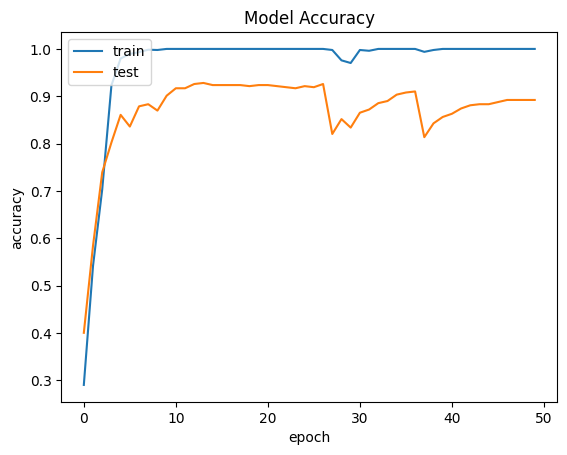

In [51]:
# plot of accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

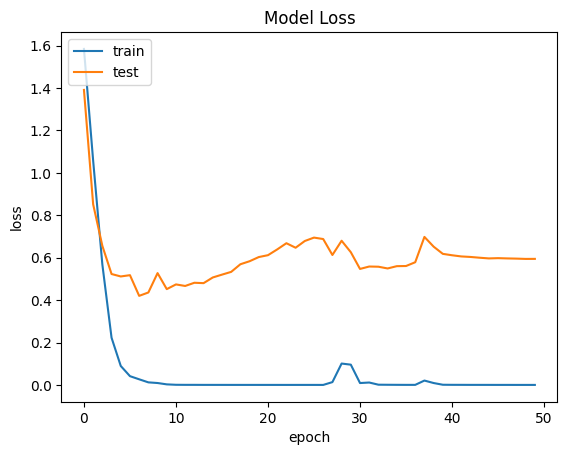

In [52]:
# plot of loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()